### The code in this Notebook is based on the proposed adaptive methods of PINN by Wight and Zhao (2020).

This Notebook involves four of the proposed methods in (Wight & Zhao, 2020), which are the (non-adaptive) weighted loss function, mini-batch training, adaptive space resampling, and adaptive time resampling.

Before implementing each method, we give a brief explanation of the method, the data used for training, and the neural network architecture. Also, the code is customized to use CPU or GPU, but in most cases, we have adapted training via mini-batch approach, so to make full use of the GPU computational power, you might need to change the size of the batch to be the same as the size of the whole data, especially when the size of the training data was not large enough.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from math import pi
from scipy.stats import qmc

# Finite Difference for a Reference Solution

In [ ]:
def init_cond(x):
  return x**2 * np.cos(np.pi * x)

In [ ]:
def cent_diff_2nd(input, step_size):
  output = np.zeros_like(input)
  output[1:-1] = input[2:] - 2 * input[1:-1] + input[:-2]
  return output / step_size**2

In [ ]:
def FD_approx(x_start, x_end, t_end, x_step, t_step):
  x_axis = np.arange(x_start, x_end + x_step, x_step)
  t_axis = np.arange(0.0, t_end + t_step, t_step)
  u_0 = init_cond(x_axis)
  u = [u_0]
  for t in range(1, len(t_axis)):
    u_prev = u[-1]
    u_next = u_prev + 0.0001 * t_step * cent_diff_2nd(u_prev, x_step) \
             - 5 * t_step * u_prev**3 + 5 * t_step * u_prev
    #apply the boundary conditions
    boundary_value = (u_next[1] + u_next[-2]) / 2
    u_next[0] = boundary_value
    u_next[-1] = boundary_value
    u.append(u_next)

  u = np.array(u)
  return u, t_axis, x_axis

In [ ]:
u_fd, t_fd, x_fd = FD_approx(-1.0, 1.0, 1.0, 0.005, 0.001)

In [ ]:
def plot_result(u, x_axis, y_axis, title="", x_label="", y_label=""):
  x_grid, y_grid = np.meshgrid(x_axis, y_axis)
  figure = plt.figure(figsize=(6, 4), dpi=100, tight_layout=True)
  ax = figure.add_subplot(1, 1, 1)
  ax.set_title(title)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  colormap = ax.pcolormesh(x_grid, y_grid, u, cmap="jet")
  plt.colorbar(colormap)
  plt.show()

## Visualize the FD solution

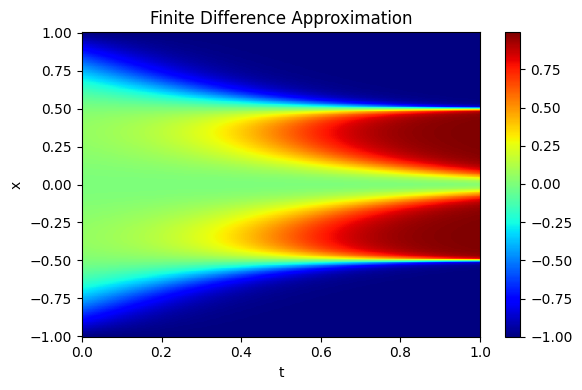

In [ ]:
plot_result(u_fd.T, t_fd, x_fd,
            title="Finite Difference Approximation",
            x_label="t", y_label="x")

### Visualize the final step

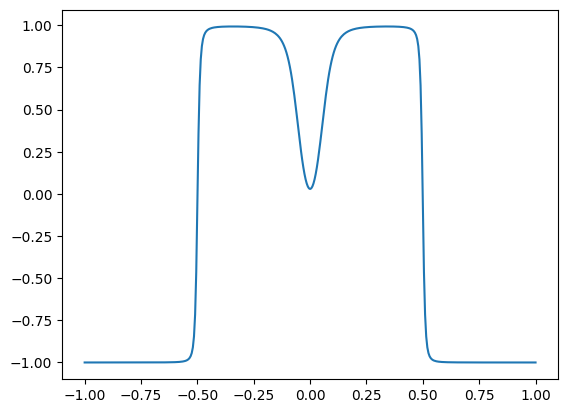

In [ ]:
plt.plot(x_fd, u_fd[-1])

# PINN Scheme

In [ ]:
# Create a class for a fully connected neural network
class FCN(nn.Module):
  def __init__(self, n_input, n_output, n_hidden_layers, n_hidden_units):
    super().__init__()
    self.input_layer = nn.Sequential(nn.Linear(n_input, n_hidden_units),
                                     nn.Tanh())
    self.output_layer = nn.Linear(n_hidden_units, n_output)
    self.hidden_layers = []
    for i in range(n_hidden_layers - 1):
      self.hidden_layers.append(nn.Linear(n_hidden_units, n_hidden_units))
      self.hidden_layers.append(nn.Tanh())
    self.hidden_layers = nn.Sequential(*self.hidden_layers)

  def forward(self, x, t):
    input = torch.cat((x, t), axis=1)
    output = self.input_layer(input)
    output = self.hidden_layers(output)
    output = self.output_layer(output)
    return output

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"You are using {device}")

You are using cpu


In [ ]:
#----initial condition-----
def u_init(x):
  u_0 = x**2 * torch.cos(pi * x)
  return u_0.to(device)

In [ ]:
x_0, x_f = -1.0, 1.0
t_0, t_f = 0.0, 1.0

#---generate training data---
#---sampling method: Latin Hypercube---
def generate_data(x_0, x_f, t_0, t_f,
                  interior_points, init_points, boundary_points, rand=True):
  if rand:
    sampler = qmc.LatinHypercube(2)
    xt_physics = sampler.random(interior_points)
    xt_physics = torch.from_numpy(xt_physics).type(torch.float32)
    x_physics, t_physics = xt_physics.split(1, 1)
    x_physics = (x_f - x_0) * x_physics + x_0
    t_physics = (t_f - t_0) * t_physics + t_0

    sampler = qmc.LatinHypercube(1)
    x_init = sampler.random(init_points)
    x_init = torch.from_numpy(x_init).type(torch.float32)
    x_init = (x_f - x_0) * x_init + x_0

    t_boundary = sampler.random(boundary_points)
    t_boundary = torch.from_numpy(t_boundary).type(torch.float32)
    t_boundary = (t_f - t_0) * t_boundary + t_0
  else:
    x_physics = torch.linspace(x_0, x_f, interior_points).unsqueeze(-1)
    t_physics = torch.linspace(t_0, t_f, interior_points).unsqueeze(-1)
    x_init = torch.linspace(x_0, x_f, init_points).unsqueeze(-1)
    t_boundary = torch.linspace(t_0, t_f, boundary_points).unsqueeze(-1)

  t_init = torch.tensor([t_0] * init_points).unsqueeze(-1)
  x_left = torch.tensor([x_0] * boundary_points).unsqueeze(-1)
  x_right = torch.tensor([x_f] * boundary_points).unsqueeze(-1)

  return x_physics.to(device), t_physics.to(device), \
          x_init.to(device), t_init.to(device), x_left.to(device), \
          x_right.to(device), t_boundary.to(device)

In [ ]:
def generate_resample_data(x_0, x_f, t_0, t_f, n_points):
  sampler = qmc.LatinHypercube(2)
  xt_physics = sampler.random(n_points)
  xt_physics = torch.from_numpy(xt_physics).type(torch.float32)
  x_physics, t_physics = xt_physics.split(1, 1)
  x_physics = (x_f - x_0) * x_physics + x_0
  t_physics = (t_f - t_0) * t_physics + t_0

  return x_physics.to(device), t_physics.to(device)

In [ ]:
def resample(PINN, optimizer, resample_size,
             x_0, x_f, t_0, t_f, n_points):
  optimizer.zero_grad()
  x_test, t_test = generate_resample_data(x_0, x_f, t_0, t_f, n_points)
  x_test = x_test.requires_grad_(True)
  t_test = t_test.requires_grad_(True)
  u = PINN(x_test, t_test)
  u_t = torch.autograd.grad(u, t_test, torch.ones_like(u), create_graph=True)[0]
  u_x = torch.autograd.grad(u, x_test, torch.ones_like(u), create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x, x_test, torch.ones_like(u_x), create_graph=True)[0]
  error = abs(u_t - 0.0001 * u_xx + 5 * u**3 - 5 * u)
  error = error.detach().squeeze()
  indices = torch.argsort(error, descending=True)[:resample_size]
  x_resampled = torch.take(x_test.squeeze().detach(), indices).unsqueeze(-1)
  t_resampled = torch.take(t_test.squeeze().detach(), indices).unsqueeze(-1)
  return x_resampled.to(device), t_resampled.to(device)

In [ ]:
def loss_fun(PINN, x_physics, t_physics, x_init,
             t_init, x_left, x_right, t_boundary,
             physics_weight, init_weight, boundary_weight):

  #-------pde loss-----
  u = PINN(x_physics, t_physics)
  u_t = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
  u_x = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x, x_physics, torch.ones_like(u_x), create_graph=True)[0]
  pde_loss = torch.mean( (u_t - 0.0001 * u_xx + 5 * u**3 - 5 * u)**2 )

  #------initial condition loss------
  u = PINN(x_init, t_init)
  init_loss = torch.mean( (u - u_init(x_init))**2 )

  #-------boundary conditions loss----
  u_left = PINN(x_left, t_boundary)
  u_x_left = torch.autograd.grad(u_left, x_left, torch.ones_like(u_left), create_graph=True)[0]
  u_right = PINN(x_right, t_boundary)
  u_x_right = torch.autograd.grad(u_right, x_right, torch.ones_like(u_right), create_graph=True)[0]
  boundary_loss1 = torch.mean( (u_left - u_right)**2 )
  boundary_loss2 = torch.mean( (u_x_left - u_x_right)**2 )
  boundary_loss = boundary_loss1 + boundary_loss2


  #------weighted loss--------
  loss =  (physics_weight * pde_loss +
           init_weight * init_loss +
           boundary_weight * boundary_loss)

  return pde_loss, init_loss, boundary_loss, loss

In [ ]:
def test_and_compare(PINN, u_fd, x_axis_fd, t_axis_fd, final_step = False):
  PINN.eval()
  with torch.inference_mode():
    x_axis_test = torch.from_numpy(x_axis_fd).type(torch.float32)
    t_axis_test =  torch.from_numpy(t_axis_fd).type(torch.float32)
    test_data = torch.cartesian_prod(x_axis_test, t_axis_test).to(device)
    x_test, t_test = test_data.split(1, 1)
    u_pinn = PINN(x_test, t_test)
    u_pinn = u_pinn.cpu()
    u_pinn = u_pinn.reshape(len(x_axis_test), len(t_axis_test)).numpy()
    u_diff = abs(u_fd.T - u_pinn)
    global_error = max(u_diff.flatten())
    plot_result(u_pinn, t_axis_test.numpy(), x_axis_test.numpy(),
                title=f"NN approximation u(x,t)",
                x_label="t", y_label="x")
    plot_result(u_diff, t_axis_fd, x_axis_fd,
                title=f"Absolute difference (global error: {global_error:.4f})",
                x_label="t", y_label="x")
    if final_step:
      figure = plt.figure()
      ax = figure.add_subplot(1, 1, 1)
      ax.plot(x_axis_fd, u_fd[-1], color="blue", label="Reference")
      ax.plot(x_axis_test, u_pinn.T[-1], color="red",
              linestyle="--", label="NN approximation")
      ax.set_xlabel("x")
      ax.set_ylabel("u(x, t = 1.0)")
      plt.legend()

  PINN.train()

#Base PINN Model

This is the time-continuous model proposed by (Raissi et al., 2019). Applying this model does not yield correct results, and hence we need to implement adaptive PINN methods to obtain a better a approximation.

In [ ]:
PINN = FCN(2, 1, 4, 128).to(device)

In [ ]:
optimizer = torch.optim.Adam(PINN.parameters(), lr=1e-3)

In [ ]:
# generate training data
n_interior = 10000
n_boundary = 200
n_init = 200
x_interior, t_interior, x_init, t_init, \
x_left, x_right, t_boundary = generate_data(x_0, x_f, t_0, t_f,
                                            n_interior, n_init, n_boundary)

x_interior.requires_grad_(True);
t_interior.requires_grad_(True);
x_left.requires_grad_(True);
x_right.requires_grad_(True);

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


-------iteration 1000------
PDE loss = 0.008332920260727406
Initial condition loss = 0.12442418187856674
Boundary conditions loss = 0.000313720665872097
Total loss = 0.13307081162929535
------------------------------------------------------------
-------iteration 2000------
PDE loss = 0.009032052010297775
Initial condition loss = 0.12265260517597198
Boundary conditions loss = 0.00018250838911626488
Total loss = 0.1318671703338623
------------------------------------------------------------
-------iteration 3000------
PDE loss = 0.010938862338662148
Initial condition loss = 0.11924748867750168
Boundary conditions loss = 4.382065526442602e-05
Total loss = 0.13023017346858978
------------------------------------------------------------
-------iteration 4000------
PDE loss = 0.01115404348820448
Initial condition loss = 0.11877816915512085
Boundary conditions loss = 2.119986129400786e-05
Total loss = 0.12995341420173645
------------------------------------------------------------
-------ite

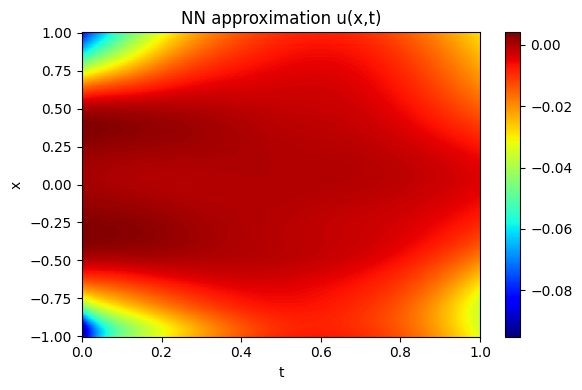

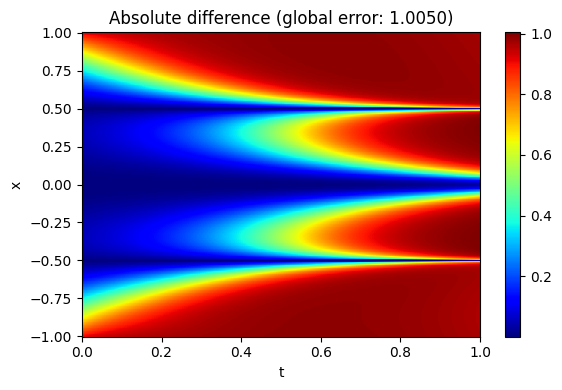

-------iteration 11000------
PDE loss = 0.011199981905519962
Initial condition loss = 0.11810152977705002
Boundary conditions loss = 4.298752173781395e-05
Total loss = 0.12934450805187225
------------------------------------------------------------
-------iteration 12000------
PDE loss = 0.012030382640659809
Initial condition loss = 0.11705178767442703
Boundary conditions loss = 6.811944331275299e-05
Total loss = 0.12915028631687164
------------------------------------------------------------
-------iteration 13000------
PDE loss = 0.01182730682194233
Initial condition loss = 0.11577041447162628
Boundary conditions loss = 0.00026800899649970233
Total loss = 0.127865731716156
------------------------------------------------------------
-------iteration 14000------
PDE loss = 0.012483883649110794
Initial condition loss = 0.11425253003835678
Boundary conditions loss = 0.000532112258952111
Total loss = 0.12726852297782898
------------------------------------------------------------
-------

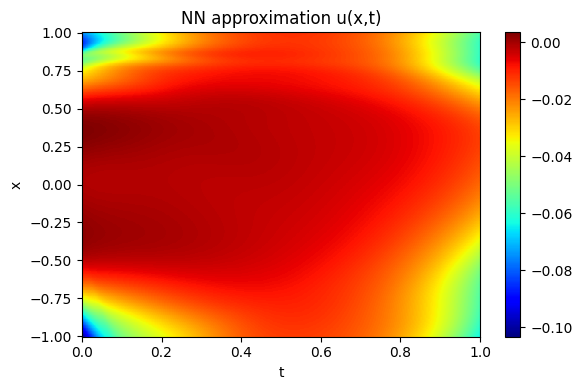

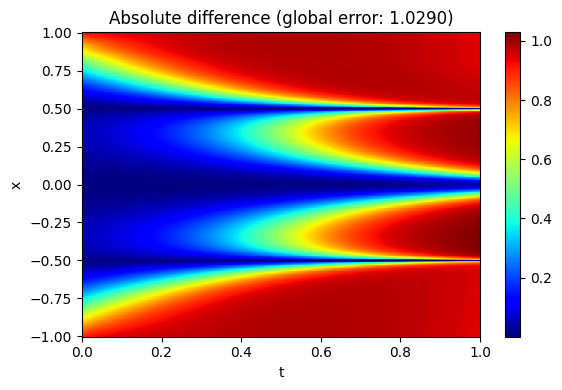

-------iteration 21000------
PDE loss = 0.011745254509150982
Initial condition loss = 0.11676380038261414
Boundary conditions loss = 0.00012213640729896724
Total loss = 0.12863118946552277
------------------------------------------------------------
-------iteration 22000------
PDE loss = 0.0118690375238657
Initial condition loss = 0.11771900206804276
Boundary conditions loss = 0.0007057670736685395
Total loss = 0.1302938014268875
------------------------------------------------------------
-------iteration 23000------
PDE loss = 0.009775552898645401
Initial condition loss = 0.12187106907367706
Boundary conditions loss = 0.0018209144473075867
Total loss = 0.13346752524375916
------------------------------------------------------------
-------iteration 24000------
PDE loss = 0.012463471852242947
Initial condition loss = 0.11497566103935242
Boundary conditions loss = 0.0003617342154029757
Total loss = 0.1278008669614792
------------------------------------------------------------
-------

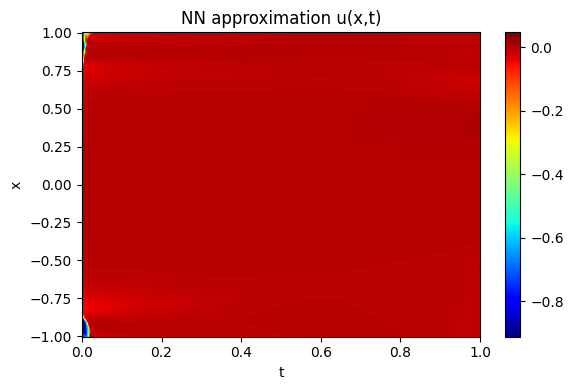

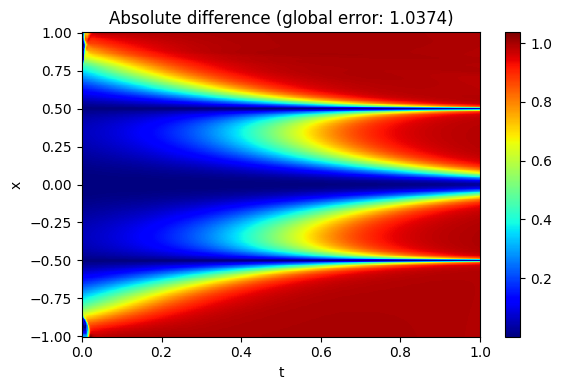

-------iteration 31000------
PDE loss = 0.0035242713056504726
Initial condition loss = 0.020377306267619133
Boundary conditions loss = 0.0012327490840107203
Total loss = 0.02513432689011097
------------------------------------------------------------
-------iteration 32000------
PDE loss = 0.007767422124743462
Initial condition loss = 0.07725481688976288
Boundary conditions loss = 0.0036945717874914408
Total loss = 0.08871681243181229
------------------------------------------------------------
-------iteration 33000------
PDE loss = 0.007557590492069721
Initial condition loss = 0.07452023774385452
Boundary conditions loss = 0.002946974243968725
Total loss = 0.08502480387687683
------------------------------------------------------------
-------iteration 34000------
PDE loss = 0.007363454904407263
Initial condition loss = 0.07319409400224686
Boundary conditions loss = 0.002392854541540146
Total loss = 0.0829503983259201
------------------------------------------------------------
-----

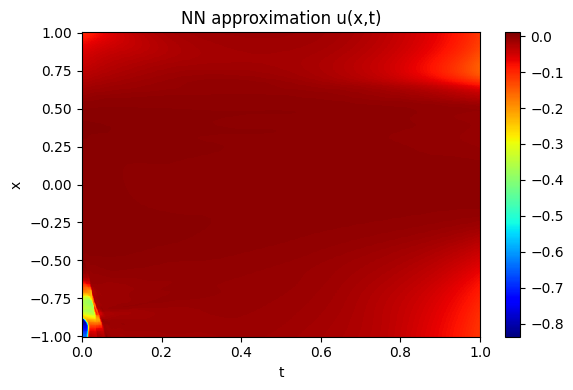

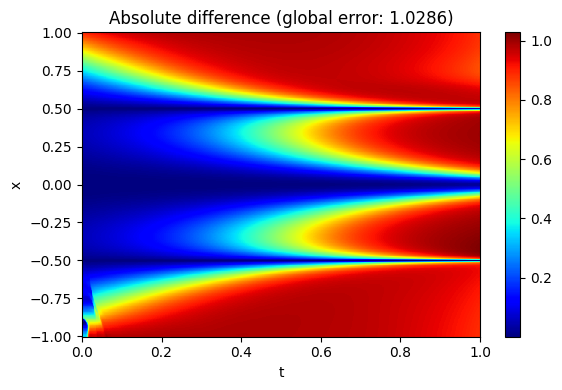

In [ ]:
#----It is recommended to use GPUs when runing this cell-----
#----Otherwise it will take a long time to finish running----
iterations = 40000

PINN.train()
for iteration in range(1, iterations + 1):
  optimizer.zero_grad()

  pde_loss, init_loss, \
  boundary_loss, loss = loss_fun(PINN, x_interior, t_interior, x_init,
                                t_init, x_left, x_right, t_boundary,
                                1, 1, 1)
  loss.backward()
  optimizer.step()

  if iteration % 1000 == 0:
    PINN.eval()
    with torch.inference_mode():
      total_loss = pde_loss + init_loss + boundary_loss
      print(f"-------iteration {iteration}------")
      print(f"PDE loss = {pde_loss}")
      print(f"Initial condition loss = {init_loss}")
      print(f"Boundary conditions loss = {boundary_loss}")
      print(f"Total loss = {total_loss}")
      print("-" * 60 )
    PINN.train()

  if iteration % 10000 == 0:
      test_and_compare(PINN, u_fd, x_fd, t_fd)

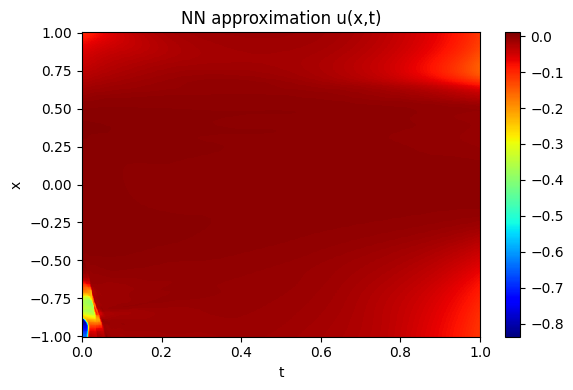

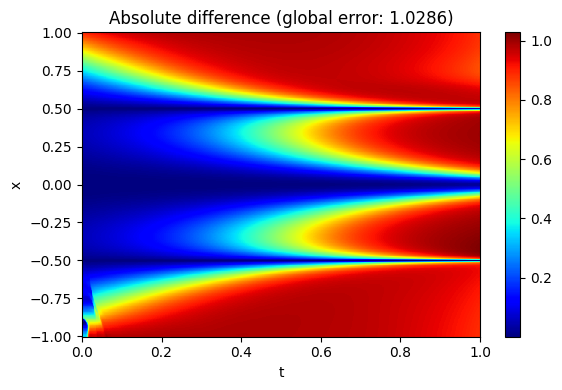

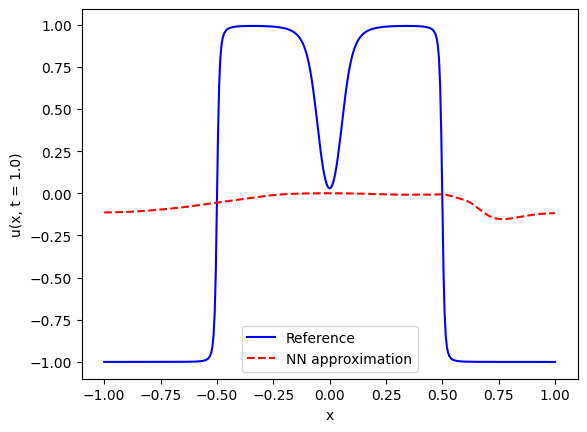

In [ ]:
test_and_compare(PINN, u_fd, x_fd, t_fd, final_step=True)

## Weighted Loss (only).
One of the proposed methods for approximating Allen-Cahn equation's solution by PINN is to use a weighted loss function. The main idea is to give a larger weight for the initial condition loss since the equation represents an irreversible phenomenon. Therefore, learning the initial step correctly is essential for learning the solution at later times.

The structure of neural network consists of 4 hidden layers, each with 128 hidden units, and Tangent hyperbolic function as an activation function. Furthermore, we first train the neural network (model) using ADAM optimizer and then refine it by LBFGS optimizer as it was mentioned in (Wight & Zhao, 2020).

Training data consists of 10,000 collocation points (residual points, PDE data points), 400 boundary condition points (200 for the left and right boundaries), and 200 initial condition points.

**Although this scheme or model produces better results than the base model, it is not able to converge to the correct solution at the last step; That is $u(x, t=1.0)$**


In [ ]:
PINN = FCN(2, 1, 4, 128).to(device)

In [ ]:
optimizer = torch.optim.Adam(PINN.parameters(), lr=1e-3)

In [ ]:
# generate training data
n_interior = 10000
n_boundary = 200
n_init = 200
x_interior, t_interior, x_init, t_init, \
x_left, x_right, t_boundary = generate_data(x_0, x_f, t_0, t_f,
                                            n_interior, n_init, n_boundary)

x_interior.requires_grad_(True);
t_interior.requires_grad_(True);
x_left.requires_grad_(True);
x_right.requires_grad_(True);

-------iteration 1000------
PDE loss = 0.9798514246940613
Initial condition loss = 0.0012065377086400986
Boundary conditions loss = 0.018399106338620186
Total loss = 0.999457061290741
------------------------------------------------------------
-------iteration 2000------
PDE loss = 0.96881502866745
Initial condition loss = 0.0010375849669799209
Boundary conditions loss = 0.012283818796277046
Total loss = 0.9821364283561707
------------------------------------------------------------
-------iteration 3000------
PDE loss = 0.9633095264434814
Initial condition loss = 0.0006549869431182742
Boundary conditions loss = 0.00626799650490284
Total loss = 0.9702325463294983
------------------------------------------------------------
-------iteration 4000------
PDE loss = 0.957298994064331
Initial condition loss = 0.000546991650480777
Boundary conditions loss = 0.003129213582724333
Total loss = 0.960975170135498
------------------------------------------------------------
-------iteration 5000--

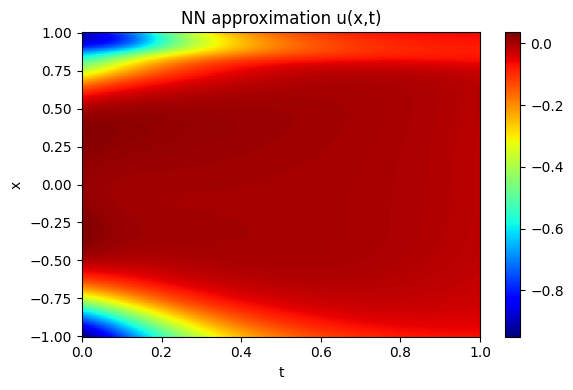

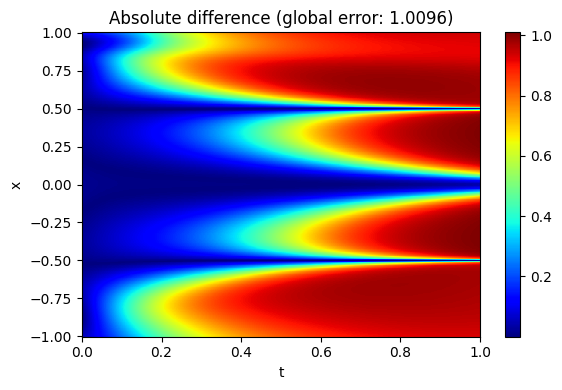

-------iteration 11000------
PDE loss = 0.9455446004867554
Initial condition loss = 0.00033902577706612647
Boundary conditions loss = 0.0005992341320961714
Total loss = 0.9464828372001648
------------------------------------------------------------
-------iteration 12000------
PDE loss = 0.9368479251861572
Initial condition loss = 0.0003213588206563145
Boundary conditions loss = 0.0009495378471910954
Total loss = 0.9381188750267029
------------------------------------------------------------
-------iteration 13000------
PDE loss = 0.051605045795440674
Initial condition loss = 0.00010780824959510937
Boundary conditions loss = 0.00259393360465765
Total loss = 0.054306790232658386
------------------------------------------------------------
-------iteration 14000------
PDE loss = 0.009977669455111027
Initial condition loss = 3.9520229620393366e-05
Boundary conditions loss = 0.0004002921050414443
Total loss = 0.010417481884360313
------------------------------------------------------------

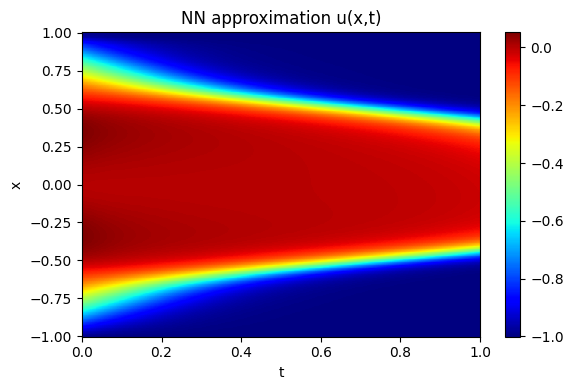

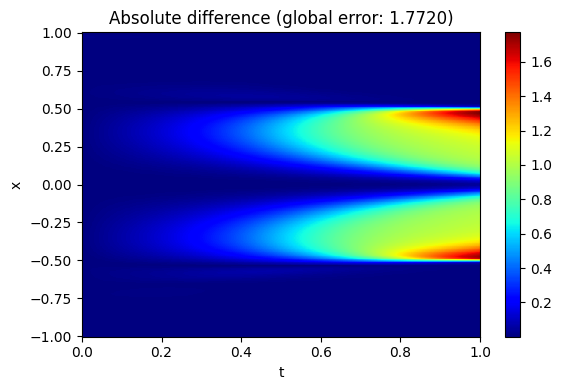

-------iteration 21000------
PDE loss = 0.010504843667149544
Initial condition loss = 3.071188984904438e-05
Boundary conditions loss = 0.00042772103915922344
Total loss = 0.010963276959955692
------------------------------------------------------------
-------iteration 22000------
PDE loss = 0.005230209790170193
Initial condition loss = 1.8092994650942273e-05
Boundary conditions loss = 3.98094198317267e-05
Total loss = 0.005288111977279186
------------------------------------------------------------
-------iteration 23000------
PDE loss = 0.007473402190953493
Initial condition loss = 3.113313505309634e-05
Boundary conditions loss = 0.00025524181546643376
Total loss = 0.0077597773633897305
------------------------------------------------------------
-------iteration 24000------
PDE loss = 0.006036955863237381
Initial condition loss = 1.2042969501635525e-05
Boundary conditions loss = 2.6609282940626144e-05
Total loss = 0.00607560807839036
-------------------------------------------------

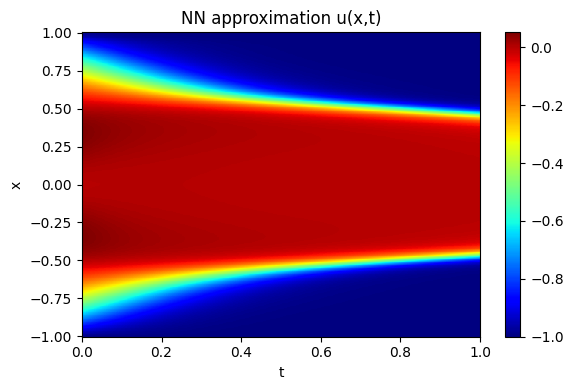

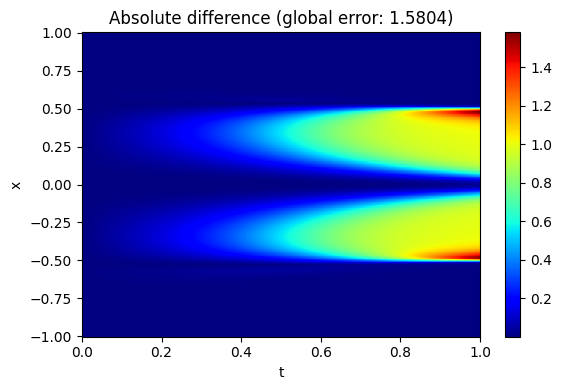

-------iteration 31000------
PDE loss = 0.005213461816310883
Initial condition loss = 1.0681551430025138e-05
Boundary conditions loss = 0.00022740747954230756
Total loss = 0.005451550707221031
------------------------------------------------------------
-------iteration 32000------
PDE loss = 0.0050796810537576675
Initial condition loss = 1.1783825357269961e-05
Boundary conditions loss = 9.096501889871433e-05
Total loss = 0.005182430148124695
------------------------------------------------------------
-------iteration 33000------
PDE loss = 0.004933719988912344
Initial condition loss = 1.3724921700486448e-05
Boundary conditions loss = 0.00014289419050328434
Total loss = 0.005090339109301567
------------------------------------------------------------
-------iteration 34000------
PDE loss = 0.005531134083867073
Initial condition loss = 1.2483636055549141e-05
Boundary conditions loss = 0.00015191046986728907
Total loss = 0.005695527885109186
---------------------------------------------

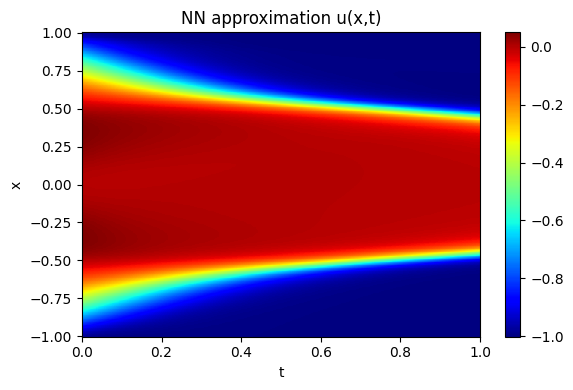

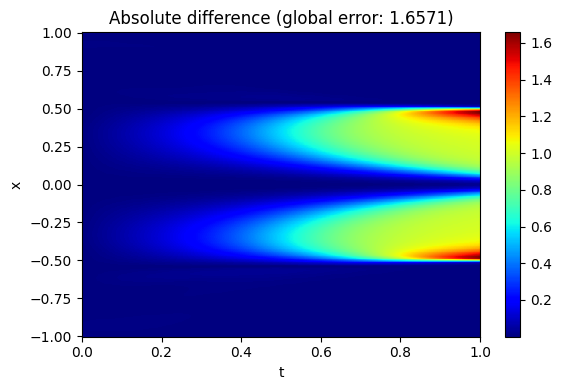

In [ ]:
#----It is recommended to use GPUs when runing this cell-----
#----Otherwise it will take a long time to finish running----
iterations = 40000

PINN.train()
for iteration in range(1, iterations + 1):
  optimizer.zero_grad()

  pde_loss, init_loss, \
  boundary_loss, loss = loss_fun(PINN, x_interior, t_interior, x_init,
                                t_init, x_left, x_right, t_boundary,
                                1, 100, 1)
  loss.backward()
  optimizer.step()

  if iteration % 1000 == 0:
    PINN.eval()
    with torch.inference_mode():
      total_loss = pde_loss + init_loss + boundary_loss
      print(f"-------iteration {iteration}------")
      print(f"PDE loss = {pde_loss}")
      print(f"Initial condition loss = {init_loss}")
      print(f"Boundary conditions loss = {boundary_loss}")
      print(f"Total loss = {total_loss}")
      print("-" * 60 )
    PINN.train()

  if iteration % 10000 == 0:
      test_and_compare(PINN, u_fd, x_fd, t_fd)

In [ ]:
#refine the model with LBFGS optimizer
iterations = 100
lbfgs_optimizer = torch.optim.LBFGS(PINN.parameters(), max_iter=100)
PINN.train()
for iteration in range(1, iterations+1):

  def closure():
    lbfgs_optimizer.zero_grad()
    pde_loss, init_loss, \
    boundary_loss, loss = loss_fun(PINN, x_interior, t_interior, x_init,
                                t_init, x_left, x_right, t_boundary,
                                1, 100, 1)
    loss.backward()
    return loss

  lbfgs_optimizer.step(closure)

  if iteration % 10 == 0:
    total_loss = closure()
    print(total_loss.item())

0.005475410260260105
0.005475410260260105
0.005475410260260105
0.005475410260260105
0.005475410260260105
0.005475410260260105
0.005475410260260105
0.005475410260260105
0.005475410260260105
0.005475410260260105


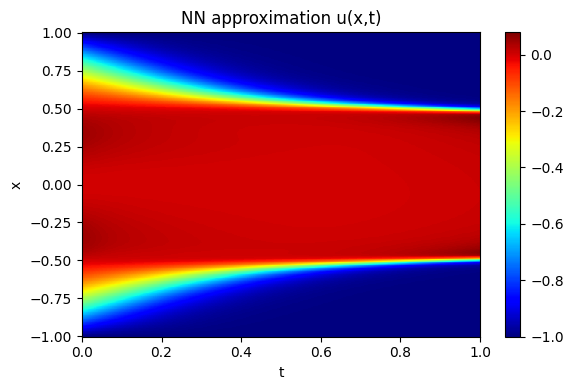

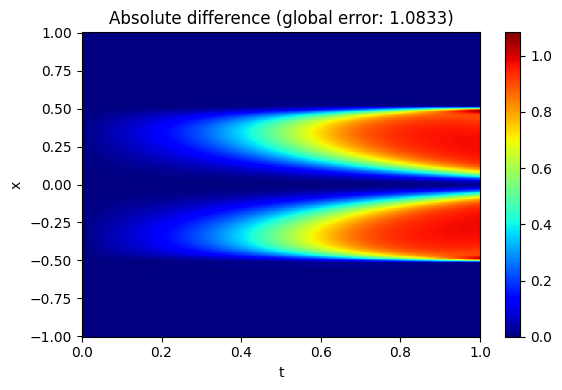

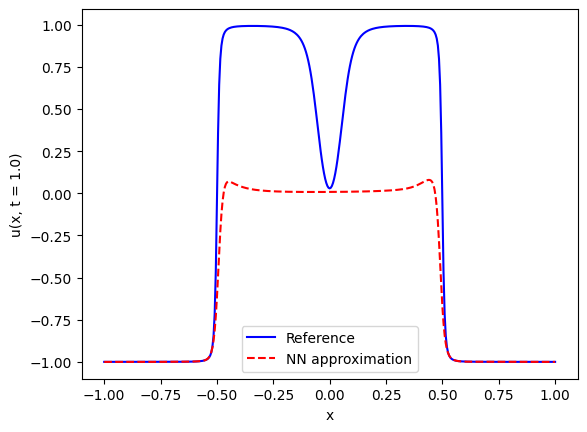

In [ ]:
test_and_compare(PINN, u_fd, x_fd, t_fd, final_step=True)

## Mini-batch training (with weighted loss).
The second method proposes the use mini-batch instead of using the entire data set to optimize the neural network's parameters. The work of Wight and Zhao (2020) used a batch size of 32, but we used here 128 batch size for the interior training data (collocation or residual data points). The data sets consist of 12,800 residual points, 512 data points for the initial value condition, and 400 data points for the boundary conditions. The structure of the neural network is similar to the structure used for training the model with full-batch.

**This approach shows a better approximation than using weighted loss function alone. Despite that, it is not able to capture the exact behavior of the solution, especially at the last instant. That is $u(x, t=1.0)$**

In [ ]:
PINN = FCN(2, 1, 4, 128).to(device)

In [ ]:
optimizer = torch.optim.Adam(PINN.parameters(), lr=1e-3)

In [ ]:
# generate training data
n_interior = 12800
n_boundary = 200
n_init = 512
x_interior, t_interior, x_init, t_init, \
x_left, x_right, t_boundary = generate_data(x_0, x_f, t_0, t_f,
                                            n_interior, n_init, n_boundary)
x_interior.requires_grad_(True);
t_interior.requires_grad_(True);
x_left.requires_grad_(True);
x_right.requires_grad_(True);

-------epoch 10------
PDE loss = 0.7721474170684814
Initial condition loss = 0.0010787735227495432
Boundary conditions loss = 0.008737710304558277
Total loss = 0.7819638848304749
------------------------------------------------------------
-------epoch 20------
PDE loss = 0.7874013185501099
Initial condition loss = 0.0007504234672524035
Boundary conditions loss = 0.003926785662770271
Total loss = 0.7920785546302795
------------------------------------------------------------
-------epoch 30------
PDE loss = 0.8350719809532166
Initial condition loss = 0.00034830396180041134
Boundary conditions loss = 0.003369518555700779
Total loss = 0.8387898206710815
------------------------------------------------------------
-------epoch 40------
PDE loss = 0.8554325103759766
Initial condition loss = 0.0002929213806055486
Boundary conditions loss = 0.008488531224429607
Total loss = 0.8642139434814453
------------------------------------------------------------
-------epoch 50------
PDE loss = 0.8580

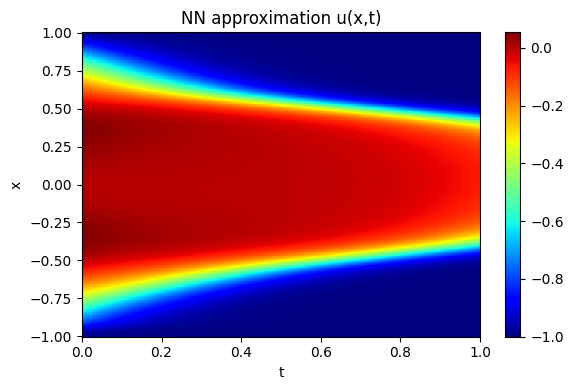

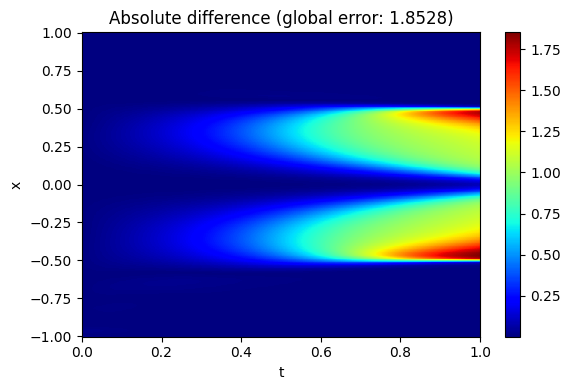

-------epoch 210------
PDE loss = 0.004641034174710512
Initial condition loss = 2.6476449420442805e-05
Boundary conditions loss = 0.000265573151409626
Total loss = 0.004933083895593882
------------------------------------------------------------
-------epoch 220------
PDE loss = 0.004412307869642973
Initial condition loss = 2.378079625486862e-05
Boundary conditions loss = 0.00038783185300417244
Total loss = 0.0048239207826554775
------------------------------------------------------------
-------epoch 230------
PDE loss = 0.004382974002510309
Initial condition loss = 2.5467597879469395e-05
Boundary conditions loss = 0.00043118902249261737
Total loss = 0.004839630331844091
------------------------------------------------------------
-------epoch 240------
PDE loss = 0.0043565076775848866
Initial condition loss = 2.5947136236936785e-05
Boundary conditions loss = 0.0002643172338139266
Total loss = 0.004646772053092718
------------------------------------------------------------
-------epo

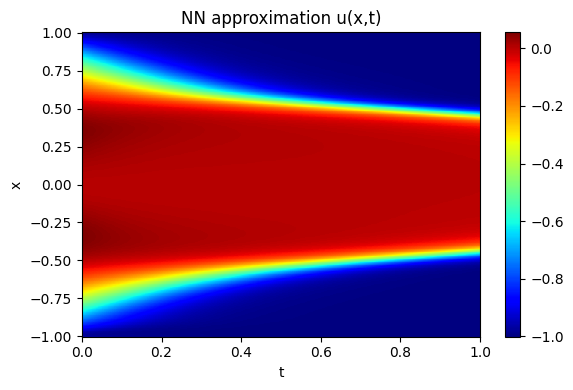

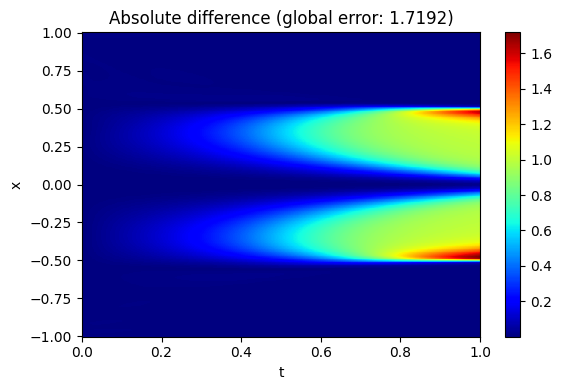

-------epoch 410------
PDE loss = 0.004063398111611605
Initial condition loss = 1.449639330530772e-05
Boundary conditions loss = 0.0013713347725570202
Total loss = 0.005449229385703802
------------------------------------------------------------
-------epoch 420------
PDE loss = 0.004160778596997261
Initial condition loss = 9.000681529869325e-06
Boundary conditions loss = 0.0018611601553857327
Total loss = 0.006030939519405365
------------------------------------------------------------
-------epoch 430------
PDE loss = 0.004211885388940573
Initial condition loss = 6.069567007216392e-06
Boundary conditions loss = 0.0019129012944176793
Total loss = 0.006130855996161699
------------------------------------------------------------
-------epoch 440------
PDE loss = 0.0040018921718001366
Initial condition loss = 7.505341272917576e-06
Boundary conditions loss = 0.0027826190926134586
Total loss = 0.006792016793042421
------------------------------------------------------------
-------epoch 45

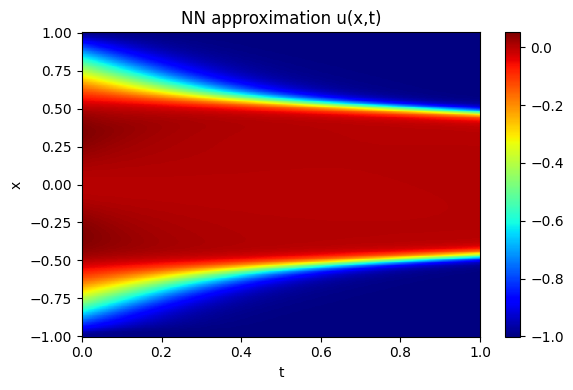

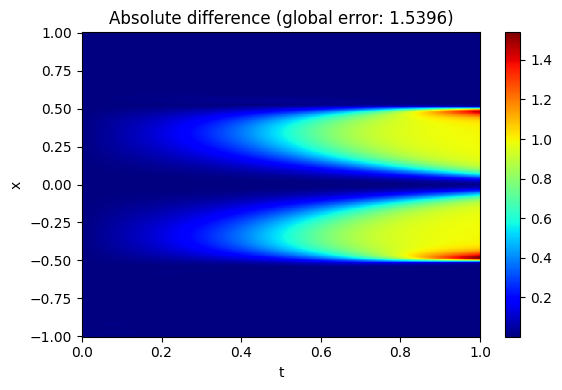

-------epoch 610------
PDE loss = 0.003741844557225704
Initial condition loss = 1.0688438123906963e-05
Boundary conditions loss = 0.0006703287945128977
Total loss = 0.0044228616170585155
------------------------------------------------------------
-------epoch 620------
PDE loss = 0.0037441635504364967
Initial condition loss = 8.818939932098147e-06
Boundary conditions loss = 0.00047887713299132884
Total loss = 0.004231859464198351
------------------------------------------------------------
-------epoch 630------
PDE loss = 0.0038496884517371655
Initial condition loss = 8.372433512704447e-06
Boundary conditions loss = 0.00033173945848830044
Total loss = 0.004189800471067429
------------------------------------------------------------
-------epoch 640------
PDE loss = 0.003960287198424339
Initial condition loss = 9.156028681900352e-06
Boundary conditions loss = 0.0001522449019830674
Total loss = 0.004121687728911638
------------------------------------------------------------
-------epo

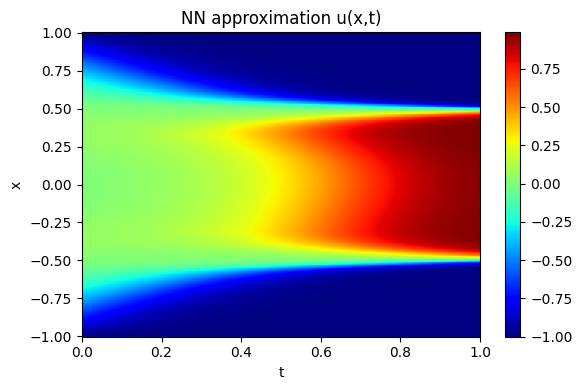

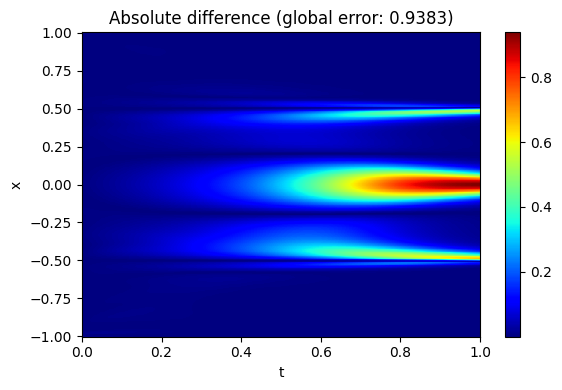

-------epoch 810------
PDE loss = 0.001840152544900775
Initial condition loss = 2.1743418983533047e-05
Boundary conditions loss = 0.00032193560036830604
Total loss = 0.0021838315296918154
------------------------------------------------------------
-------epoch 820------
PDE loss = 0.0014006341807544231
Initial condition loss = 1.3492895050148945e-05
Boundary conditions loss = 0.00012654239253606647
Total loss = 0.001540669472888112
------------------------------------------------------------
-------epoch 830------
PDE loss = 0.000747635611332953
Initial condition loss = 3.4488525670894887e-06
Boundary conditions loss = 5.455767677631229e-05
Total loss = 0.0008056421647779644
------------------------------------------------------------
-------epoch 840------
PDE loss = 0.0009593364084139466
Initial condition loss = 3.567018438843661e-06
Boundary conditions loss = 6.891178782097995e-05
Total loss = 0.0010318151907995343
------------------------------------------------------------
------

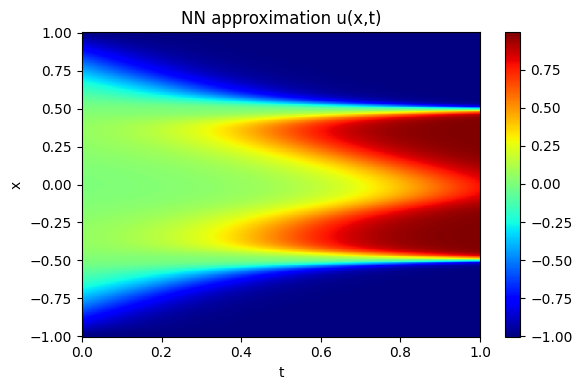

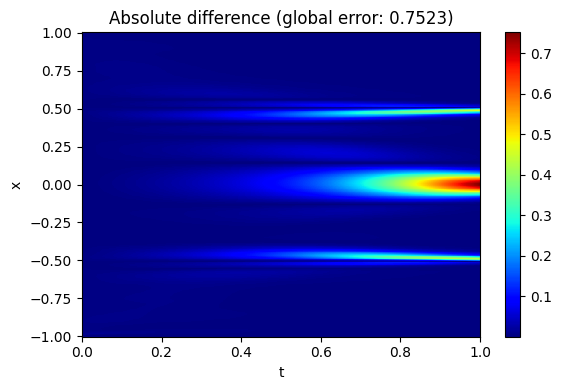

-------epoch 1010------
PDE loss = 0.0003791952913161367
Initial condition loss = 7.410169928334653e-06
Boundary conditions loss = 8.515453373547643e-05
Total loss = 0.0004717599949799478
------------------------------------------------------------
-------epoch 1020------
PDE loss = 0.0003518021258059889
Initial condition loss = 1.3525116173696006e-06
Boundary conditions loss = 3.3060929126804695e-05
Total loss = 0.00038621557177975774
------------------------------------------------------------
-------epoch 1030------
PDE loss = 0.0002153091481886804
Initial condition loss = 6.835883255007502e-07
Boundary conditions loss = 1.7897855286719278e-05
Total loss = 0.00023389059060718864
------------------------------------------------------------
-------epoch 1040------
PDE loss = 0.00022666031145490706
Initial condition loss = 1.4080416121942108e-06
Boundary conditions loss = 6.78020078339614e-05
Total loss = 0.0002958703553304076
-----------------------------------------------------------

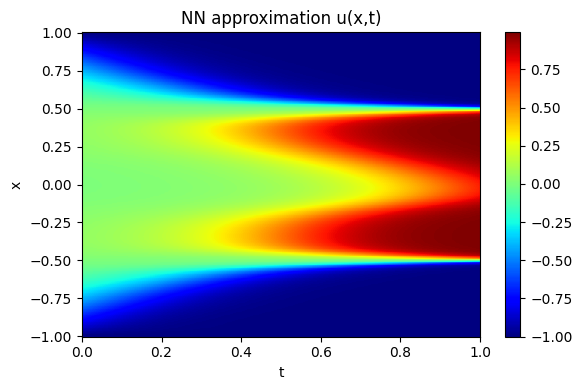

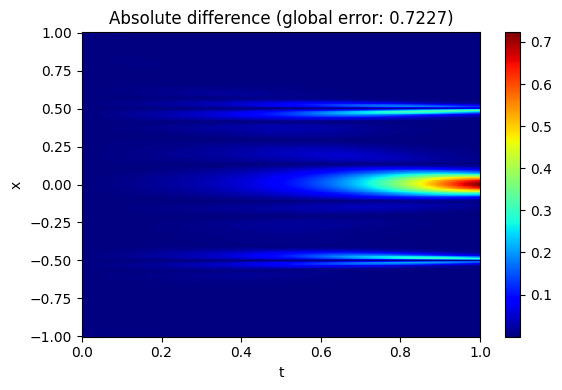

In [ ]:
epochs = 1200
batch_size = 128
iterations = int(n_interior / batch_size)


PINN.train()
for epoch in range(1, epochs + 1):

  for i in range(iterations):
    x_interior_batch = x_interior[i*batch_size: (i+1)*batch_size]
    t_interior_batch = t_interior[i*batch_size: (i+1)*batch_size]
    optimizer.zero_grad()

    pde_loss, init_loss, \
    boundary_loss, loss = loss_fun(PINN, x_interior_batch, t_interior_batch,
                                   x_init, t_init, x_left, x_right, t_boundary,
                                  1, 100, 1)
    loss.backward()
    optimizer.step()

  if epoch % 10 == 0:
    PINN.eval()
    with torch.inference_mode():
      total_loss = pde_loss + init_loss + boundary_loss
      print(f"-------epoch {epoch}------")
      print(f"PDE loss = {pde_loss}")
      print(f"Initial condition loss = {init_loss}")
      print(f"Boundary conditions loss = {boundary_loss}")
      print(f"Total loss = {total_loss}")
      print("-" * 60 )
    PINN.train()

  if epoch % 200 == 0:
    test_and_compare(PINN, u_fd, x_fd, t_fd)

In [ ]:
#refine the model with LBFGS optimizer
iterations = 100
lbfgs_optimizer = torch.optim.LBFGS(PINN.parameters(), max_iter=100)
PINN.train()
for iteration in range(1, iterations+1):

  def closure():
    lbfgs_optimizer.zero_grad()
    pde_loss, init_loss, \
    boundary_loss, loss = loss_fun(PINN, x_interior, t_interior, x_init,
                                t_init, x_left, x_right, t_boundary,
                                1, 100, 1)
    loss.backward()
    return loss

  lbfgs_optimizer.step(closure)

  if iteration % 10 == 0:
    total_loss = closure()
    print(total_loss.item())

0.00011451327009126544
7.851175905670971e-05
6.420405406970531e-05
5.69852527405601e-05
5.0230381020810455e-05
4.62826355942525e-05
4.159868331043981e-05
3.9216538425534964e-05
3.584425576264039e-05
3.382413342478685e-05


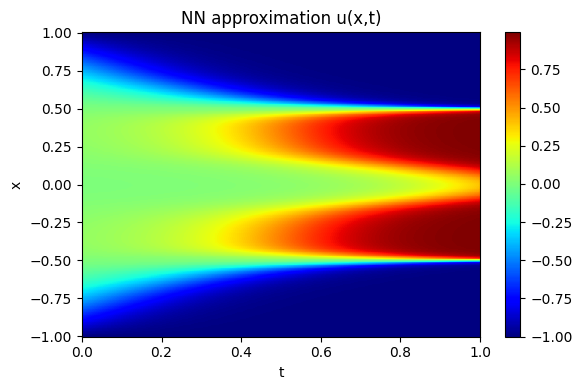

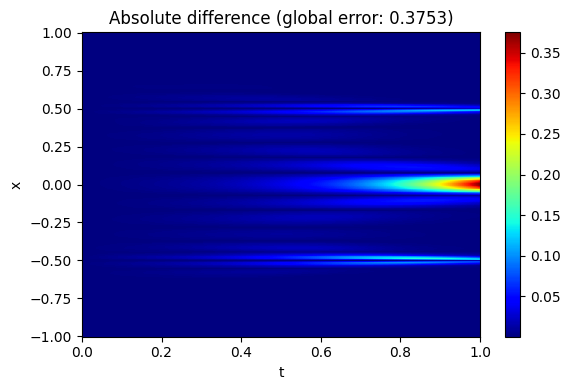

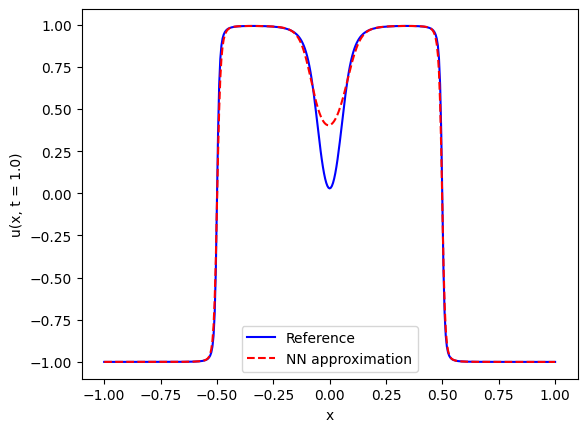

In [ ]:
test_and_compare(PINN, u_fd, x_fd, t_fd, final_step=True)

# Space Resampling (with weighted loss & mini-batch)

The idea behind the adaptive space resampling method is to start training the model with some initial set of data. Then after training the model for some number of iterations, we stop middle of the training process, resample data from the interior of the domain (collocation or residual points), and test the model using the PDE loss for the residual points. After that, we include the points with the highest error values with the original data points and resume the training process. This procedure can be repeated few times during training.

**Note**: The original data set (the initial data set) should not be changed at all, but the resampled points are to be replaced after each resampling iteration.

**Note**: You may keep the resampled data with original ones, but the number data points will keep on increasing, and hence the computational cost will increase after each resampling iteration.

In our implementation, we followed the same procedure in (Wight & Zhao, 2020) where we start with 2000 residual points and at each resampling iteration, we added the 200 points with the highest errors, but ***we do not keep the points from the previous resampling iterations***. The neural network architecture is the same as in the previous implementations.

The space resampling method produces similar results to the mini-batch approach, but the former is computationally more efficient than the previous methods as it uses 2000 residual points only.

In [ ]:
PINN = FCN(2, 1, 4, 128).to(device)
optimizer = torch.optim.Adam(PINN.parameters(), lr=1e-3)

In [ ]:
# generate training data
n_interior = 2000
n_boundary = 200
n_init = 512
x_interior, t_interior, x_init, t_init, \
x_left, x_right, t_boundary = generate_data(x_0, x_f, t_0, t_f,
                                            n_interior, n_init, n_boundary)
x_interior_copy = torch.clone(x_interior)
t_interior_copy = torch.clone(t_interior)
x_interior.requires_grad_(True);
t_interior.requires_grad_(True);
x_left.requires_grad_(True);
x_right.requires_grad_(True);

In [ ]:
epochs = 10000
batch_size = 100
iterations = int(n_interior / batch_size)
show_resmaple_loc = True
resample_size = 200

PINN.train()
for epoch in range(1, epochs + 1):

  for i in range(iterations):
    optimizer.zero_grad()
    x_interior_batch = x_interior[i*batch_size: (i+1)*batch_size]
    t_interior_batch = t_interior[i*batch_size: (i+1)*batch_size]

    pde_loss, init_loss, \
    boundary_loss, loss = loss_fun(PINN, x_interior_batch, t_interior_batch,
                                   x_init, t_init, x_left, x_right, t_boundary,
                                  1, 100, 1)
    loss.backward()
    optimizer.step()

  if epoch % 100 == 0:
    PINN.eval()
    with torch.inference_mode():
      total_loss = pde_loss + init_loss + boundary_loss
      print(f"-------epoch {epoch}------")
      print(f"PDE loss = {pde_loss}")
      print(f"Initial condition loss = {init_loss}")
      print(f"Boundary conditions loss = {boundary_loss}")
      print(f"Total loss = {total_loss}")
      print("-" * 60 )
    PINN.train()

  if epoch % 1000 == 0:
    test_and_compare(PINN, u_fd, x_fd, t_fd)

  if epoch % 100 == 0:
    print(">>>>>>resampling>>>>>>>>")
    x_resampled, t_resampled = resample(PINN, optimizer, resample_size,
                                        -1.0, 1.0, 0.0, 1.0, 10000)

    x_interior = torch.cat((x_interior_copy, x_resampled), dim=0)
    t_interior = torch.cat((t_interior_copy, t_resampled), dim=0)
    index = torch.randperm(len(x_interior)).to(device)
    x_interior = torch.take(x_interior, index).unsqueeze(-1).requires_grad_(True)
    t_interior = torch.take(t_interior, index).unsqueeze(-1).requires_grad_(True)

    if show_resmaple_loc:
      figure = plt.figure()
      ax = figure.add_subplot(1, 1, 1)
      ax.plot(t_resampled.cpu().squeeze(), x_resampled.cpu().squeeze(),
              linestyle="None",
              marker="*")
      ax.set_title("Resampled points locations")
      ax.set_ylabel("x points")
      ax.set_xlabel("t points")
      ax.set_xlim(t_0, t_f)
      ax.set_ylim(x_0, x_f)
      plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#refine the model with LBFGS optimizer
iterations = 100
lbfgs_optimizer = torch.optim.LBFGS(PINN.parameters(), max_iter=100)
PINN.train()
for iteration in range(1, iterations+1):

  def closure():
    lbfgs_optimizer.zero_grad()
    pde_loss, init_loss, \
    boundary_loss, loss = loss_fun(PINN, x_interior, t_interior, x_init,
                                t_init, x_left, x_right, t_boundary,
                                1, 100, 1)
    loss.backward()
    return loss

  lbfgs_optimizer.step(closure)

  if iteration % 10 == 0:
    total_loss = closure()
    print(total_loss.item())

3.013019340869505e-05
1.9503348084981553e-05
1.5537760191364214e-05
1.4712491065438371e-05
1.4007393474457785e-05
1.4007393474457785e-05
1.4007393474457785e-05
1.4007393474457785e-05
1.4007393474457785e-05
1.4007393474457785e-05


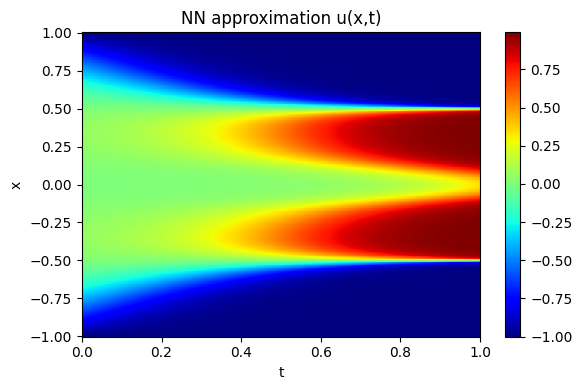

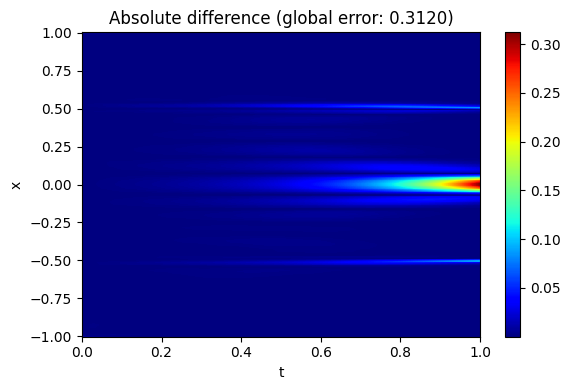

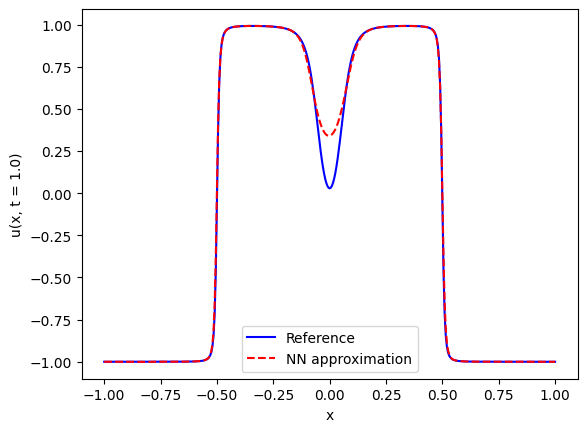

In [ ]:
test_and_compare(PINN, u_fd, x_fd, t_fd, final_step=True)

# Time Resampling

The time resampling method is an adaptive method where the time domain is divided into smaller sub-intervals. Then the Neural Network is trained for each sub-interval, consecutively. For example, in our case, the space is the interval [-1.0, 1.0] and the time is the interval [0.0, 1.0]. To perform time resampling, we can use a step size of $\Delta t = 0.1$ for instance. Then we start by training the model on the domain $[-1.0, 1.0] \; \times \; [0.0, 0.1]$. After training the model for time interval [0.0, 0.1], we expand the time interval to [0.0, 0.2]. This procedure will continue for $[0.0, 0.3], [0.0, 0.4], \dots, [0.0, 1.0]$. In other words, until we done training the model for the whole time interval, [0.0, 1.0].

**Note**: We should always include training points from the previous intervals, so we do not lose the information obtained from training the model on the previous intervals.

**Note**: The space interval, [-1.0, 1.0], is kept the same as we expand the time interval.

The time resampling method shows a better approximation than all previous methods, especially when using a small step size for discretizing the time interval.

In [ ]:
PINN = FCN(2, 1, 4, 64).to(device)

In [ ]:
optimizer = torch.optim.Adam(PINN.parameters(), lr=1e-3)

In [ ]:
dt = 0.05
t = t_0 # current step
num_steps = int( (t_f - t_0) / dt )
n_interior = 128 * 50
n_boundary = 200
n_init = 512
batch_size = 128
iterations = int(n_interior / batch_size)
resample_period = 5000
resample_size = 200

for j in range(0, num_steps):
  t += dt
  x_interior, t_interior, x_init, t_init, \
  x_left, x_right, t_boundary = generate_data(x_0, x_f, t_0, t,
                                              n_interior,n_init,n_boundary)

  #-----add gard-----
  x_interior.requires_grad_(True)
  t_interior.requires_grad_(True)
  x_left.requires_grad_(True)
  x_right.requires_grad_(True)

  #------start training----
  print(f"Starting the training for interval [{t_0}, {t:.3f}]")
  print("_" * 60)
  max_epochs = 500
  threshold = 1e-6
  epoch = 1
  total_loss = 100
  PINN.train()
  while (total_loss > threshold and epoch < max_epochs):
    for i in range(iterations):
      optimizer.zero_grad()

      x_interior_batch = x_interior[i * batch_size: (i+1) * batch_size]
      t_interior_batch = t_interior[i * batch_size: (i+1) * batch_size]

      pde_loss, init_loss,  \
      boundary_loss, loss = loss_fun(PINN, x_interior_batch, t_interior_batch,
                                    x_init, t_init, x_left, x_right,
                                    t_boundary, 1, 1, 1)
      loss.backward()
      optimizer.step()

    epoch += 1
    #------Loss information-----
    if epoch % 100 == 0:
      PINN.eval()
      with torch.inference_mode():
        total_loss = (pde_loss + init_loss + boundary_loss)
        print(f"This is epoch: {epoch}")
        print(f"PDE loss = {pde_loss}")
        print(f"Initial loss = {init_loss}")
        print(f"Boundary loss = {boundary_loss}")
        print(f"Total loss = {total_loss}")
        print("_" * 60)

      PINN.train()
  #-----information about each training interval------
  print(f"Last total loss = {total_loss}\n at epoch = {epoch}")

Starting the training for interval [0.0, 0.050]
____________________________________________________________
This is epoch: 100
PDE loss = 0.00603192625567317
Initial loss = 0.00998964998871088
Boundary loss = 0.0004305456532165408
Total loss = 0.01645212061703205
____________________________________________________________
This is epoch: 200
PDE loss = 0.0008629532530903816
Initial loss = 0.0013069510459899902
Boundary loss = 0.001019943505525589
Total loss = 0.003189847804605961
____________________________________________________________
This is epoch: 300
PDE loss = 0.00022565768449567258
Initial loss = 0.0010328085627406836
Boundary loss = 0.0003516798897180706
Total loss = 0.0016101461369544268
____________________________________________________________
This is epoch: 400
PDE loss = 0.0022447993978857994
Initial loss = 0.0009316108771599829
Boundary loss = 0.0009128950769081712
Total loss = 0.004089305177330971
____________________________________________________________
This is

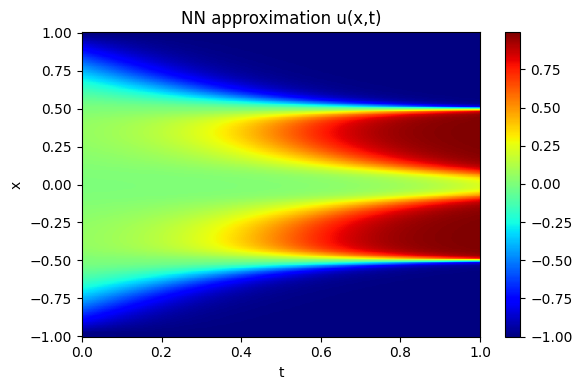

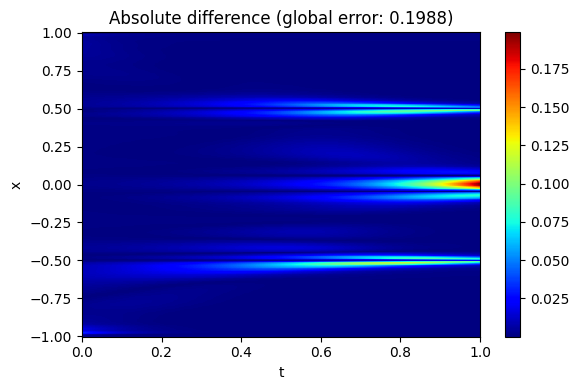

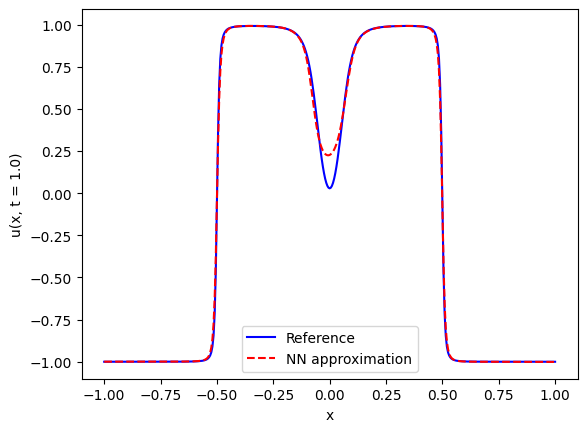

In [ ]:
test_and_compare(PINN, u_fd, x_fd, t_fd, final_step=True)

# References

[1] Zhao, C. L. (2021). Solving Allen-Cahn and Cahn-Hilliard equations using the adaptive physics informed Neural Networks. Communications in Computational Physics, 29(3), 930–954. https://doi.org/10.4208/cicp.oa-2020-0086

[2] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed Neural Networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics, 378, 686–707. https://doi.org/10.1016/j.jcp.2018.10.045